# Predicting a driver's lifetime value

**Objective:** Predict the customer lifetime value for non-contractual workers. In this instance, we estimate the 
    lifetime value for drivers given the number of trips that they have taken from the 28th of March to the 
    27 of June 2016. We start off by:
    
   1. Joining data sets
   2. Data Cleaning and Data Quality checks
   3. Feature Engineering
   4. Exploratory data analysis
   5. Model fitting


##### Load libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import scipy.stats as stats
import os
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
cd /home/simphiwe/Documents/notebooks/Customer_lifecycle

/home/simphiwe/Documents/notebooks/Customer_lifecycle


In [3]:
driver_ids = pd.read_csv('driver_ids.csv') 
ride_ids = pd.read_csv('ride_ids.csv')
ride_timestamp = pd.read_csv('ride_timestamps.csv')

#### Join driver id data to the rider id and finally merge that data to the rider data

In [4]:
rd = pd.merge(pd.merge(ride_ids, driver_ids, on='driver_id', how='inner'), ride_timestamp, on='ride_id', how='inner') 

In [5]:
rd.shape #We have just under a million rows and 8 columns after our merger

(921045, 8)

#### Classifying dtypes of columns correctly

In [6]:
for col in ['timestamp', 'driver_onboard_date' ]:
    rd[col] = pd.to_datetime(rd[col])

In [7]:
rd['event'] = rd['event'].astype('category')

In [8]:
rd.dtypes

driver_id                      object
ride_id                        object
ride_distance                   int64
ride_duration                   int64
ride_prime_time                 int64
driver_onboard_date    datetime64[ns]
event                        category
timestamp              datetime64[ns]
dtype: object

In [9]:
rd['timestamp'].nunique()

825564

In [10]:
rd['timestamp'].size

921045

In [11]:
rd['event'].dtypes

CategoricalDtype(categories=['accepted_at', 'arrived_at', 'dropped_off_at',
                  'picked_up_at', 'requested_at'],
                 ordered=False)

## 1. Feature Engineering

#### Year, month, day and hour of the week extraction

In [12]:
rd['day_of_week'] = rd['timestamp'].dt.weekday_name #Name of the week

In [13]:
rd['hours'] = rd['timestamp'].dt.hour  #Hour
#rd['month'] = rd['timestamp'].dt.month_name() #month
rd['year'] = rd['timestamp'].dt.year #year
rd['day'] = rd['timestamp'].dt.day #day
rd['date'] = pd.to_datetime(rd['timestamp'].dt.date) #date w/o time


##### Creating a categorical Variable for times of the day

In [14]:
def hour_cat(hour):
    return (
        "morning" if 5 <= hour < 12
        else
        "afternoon" if 12 <= hour < 17
        else
        "evening" if 17 <= hour <= 21
        else
        "night"
    )

In [15]:
rd['hour_category'] = rd.hours.apply(hour_cat)

In [16]:
#Creating a variable that classifies our 30 day period as a month
m1 = (rd['timestamp'] >= '2016-03-28 00:00:00') & (rd['timestamp']  < '2016-04-27 00:00:00')
m2 = (rd['timestamp']  >= '2016-04-27 00:00:00') & (rd['timestamp']  <='2016-05-27 00:00:00')
m3 = (rd['timestamp']  >= '2016-05-28 00:00:00') & (rd['timestamp']  <= '2016-06-27 00:00:00')
rd['month'] = np.select([m1, m2, m3], ['March/April','April/May','May/June'], default=np.nan)

#### Creating time variables for analysis

In [17]:
#by driver, we want to sort the timestamps and get the last timestamp a driver was active on the platform
rd['driver_last_activity' ]  = rd.groupby('driver_id')['timestamp'].transform('max')

#Create a column with the last of analysis. Assuming its the last day of the timestamp we have.
rd['Fday_of_analysis'] = rd['timestamp'].max()

#From the last time the driver was on the platform, we want calculate how long the driver has been with the platform
rd['days_active'] = (rd['driver_onboard_date'] - rd['driver_last_activity']).abs().dt.days

#Days last active on the platform
rd['days_last_active'] = (rd['Fday_of_analysis'] - rd['driver_last_activity']).abs().dt.days

In [18]:
#Extract timestamps that correspond with certain events

a = rd.loc[rd['event']=='accepted_at'].reset_index()['timestamp']
b = rd.loc[rd['event']=='arrived_at'].reset_index()['timestamp']
c = rd.loc[rd['event']=='requested_at'].reset_index()['timestamp']
d = rd.loc[rd['event']=='picked_up_at'].reset_index()['timestamp']

In [19]:
#Calculate the difference in timestamps. Then we convert to an integer minute value

rd['driver_waiting'] = d.sub(b) / np.timedelta64(1, 'm')
rd['rider_waiting'] = a.sub(c) / np.timedelta64(1, 'm')

## 2. Data Quality and Outlier Detection

In [20]:
rd.describe() #Theres an absolute max and minimum that doesn't make any sense

,ride_distance,ride_duration,ride_prime_time,hours,year,day,days_active,days_last_active,driver_waiting,rider_waiting
count,921045.000000,921045.000000,921045.000000,921044.000000,921044.0,921044.000000,921045.000000,921045.000000,184208.000000,184209.000000
mean,6945.197042,859.872292,17.373880,14.187869,2016.0,15.933523,64.431836,4.628737,0.088896,0.194343
std,8937.996535,572.844902,30.833491,6.352066,0.0,8.392571,16.453072,10.810849,0.563079,0.608589
min,-2.000000,2.000000,0.000000,0.000000,2016.0,1.000000,1.000000,0.000000,-57.933333,0.000000
25%,2457.000000,492.000000,0.000000,10.000000,2016.0,9.000000,53.000000,0.000000,0.016667,0.083333
50%,4007.000000,727.000000,0.000000,15.000000,2016.0,16.000000,66.000000,1.000000,0.050000,0.100000
75%,7169.000000,1070.000000,25.000000,19.000000,2016.0,23.000000,78.000000,3.000000,0.066667,0.150000
max,724679.000000,28204.000000,500.000000,23.000000,2016.0,31.000000,90.000000,88.000000,13.850000,83.800000


##### Detecting outliers

In [21]:
#Convert seconds to hour and metres to km
y= rd['ride_distance']/1000
x= rd['ride_duration']/3600

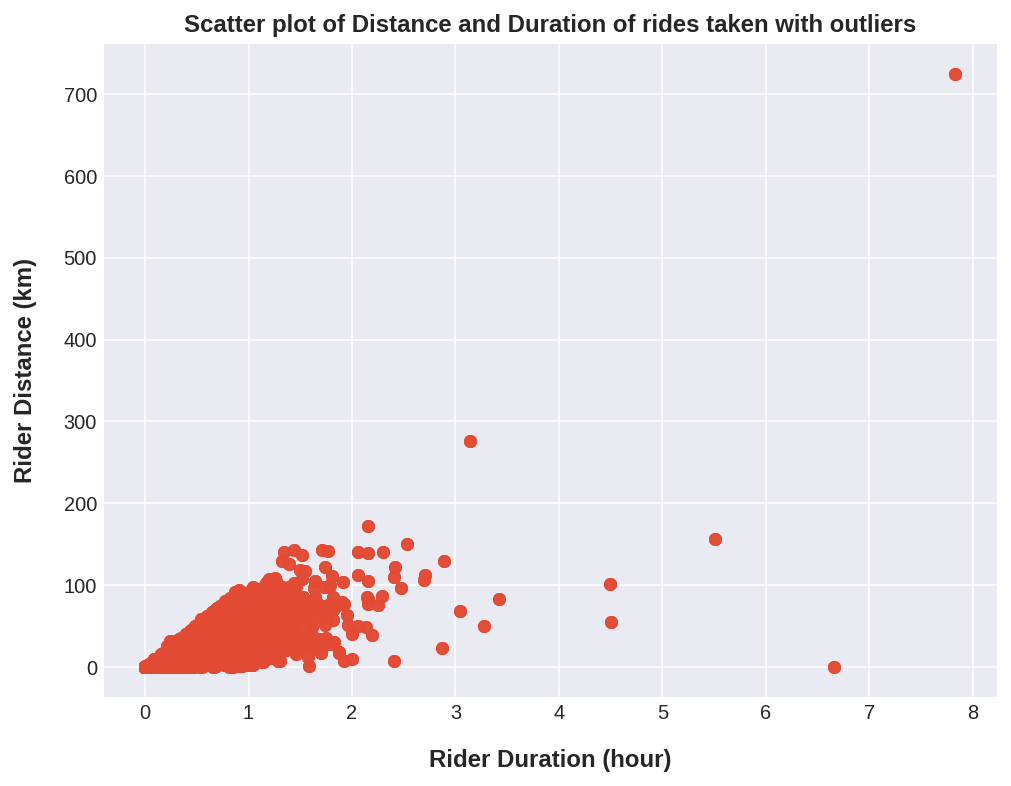

In [89]:
#A Quick visualisation of the two metrics

#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)

#Graph
plt.scatter(x, y, alpha=0.5)

#Axis labels
plt.xlabel('Rider Duration (hour)',  fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Rider Distance (km)',  fontweight='bold', labelpad=13, fontsize=12)
plt.title('Scatter plot of Distance and Duration of rides taken with outliers', fontweight='bold', fontsize=12)


plt.show()

##### Z-statistic/score

The best way to detect outliers is to measure how far off they are from the mean in terms of the standard deviation, we can use the z score to calculate this. The z-score is given by:
\begin{gather*}
z=\ \dfrac{x\ -\ \mu }{\sigma }\\
\\
\mu \ =\ mean\\
\sigma \ =standard\ deviation\\
\end{gather*}


 

#### We know that distance and time are strongly correlated to each other, we can simply work with one of the variables and clean that out. 
Disclaimer:This is not always true, it depends on the variables that you are working with.

More specifically:

In [22]:
 rd['ride_distance'].corr(rd['ride_duration'])

0.7901396161831608

In [23]:
rd['ride_duration_z'] = np.abs(stats.zscore(x)) #create and absolute value z-statistic
rd['ride_distance_z'] = np.abs(stats.zscore(x)) 

In [24]:
outliers= (rd['ride_duration_z']>3).sum()
inliers = (rd['ride_duration_z']<=3).sum()
percentage = (outliers/(outliers+inliers))*100
print('Our data contains %d outliers' %outliers)
print('Our data contains %d inliers that are not extreme values' %inliers)
print('Approximately %d percent of the sample contains outliers' %percentage)

Our data contains 15130 outliers
Our data contains 905915 inliers that are not extreme values
Approximately 1 percent of the sample contains outliers


#### Let's drop the outliers from our analysis

In [25]:
df1 = rd.drop(rd[rd['ride_duration_z'] > 3].index)

In [26]:
df = rd.drop(rd[rd['ride_distance_z'] > 3].index)

#### A Quick visualisation of the two metrics once we have removed the outliers

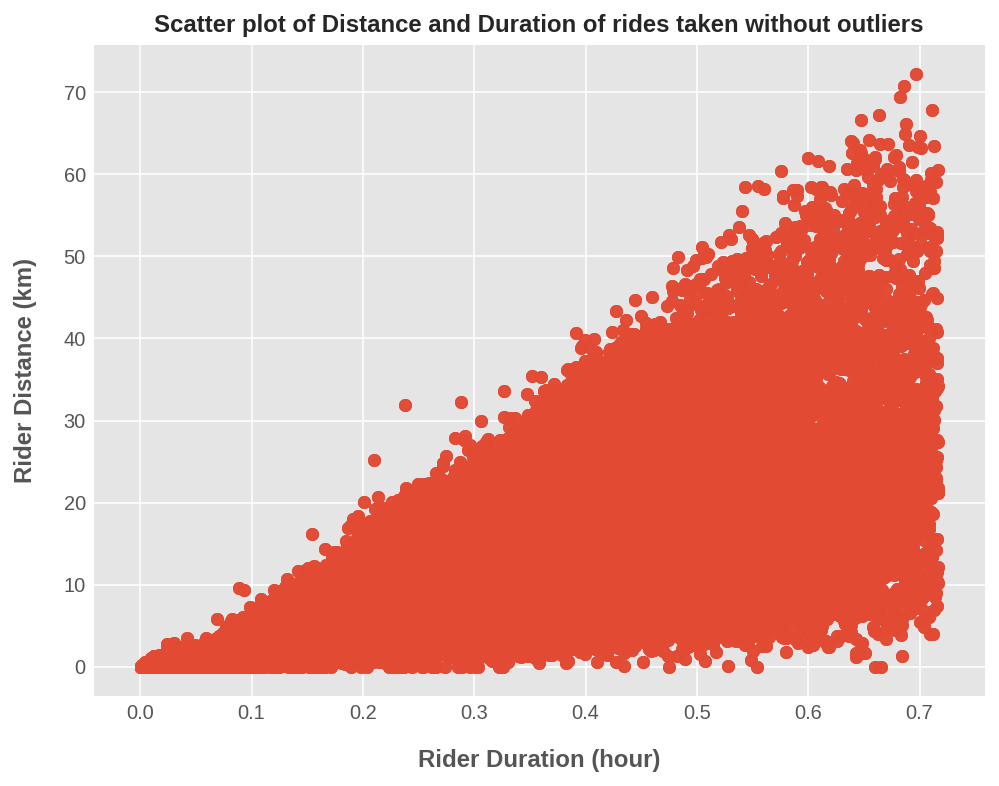

In [95]:
#Convert seconds to hour and metres to km

n = df['ride_distance']/1000
m= df['ride_duration']/3600

#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)

#Plot the graph

plt.style.use('ggplot')
plt.scatter(m, n, alpha=0.5)

#The axis
plt.xlabel('Rider Duration (hour)',  fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Rider Distance (km)',  fontweight='bold', labelpad=13, fontsize=12)
plt.title('Scatter plot of Distance and Duration of rides taken without outliers', fontweight='bold', fontsize=12)

plt.show()

## 3. Exploratory Statistics

#### Now that we have gotten rid of the outliers, we can try to visualise the distribution of the distance and the duration
 - We basically snipped the tail of the distribution if any observation lies more than 3 standard deviations from the mean
 - ##### Note:
   A kernel density estimation (KDE) is a way to estimate the probability density function (PDF) of the random variable that   “underlies” our sample. KDE is a means of data smoothing.

  #### 1. Distance

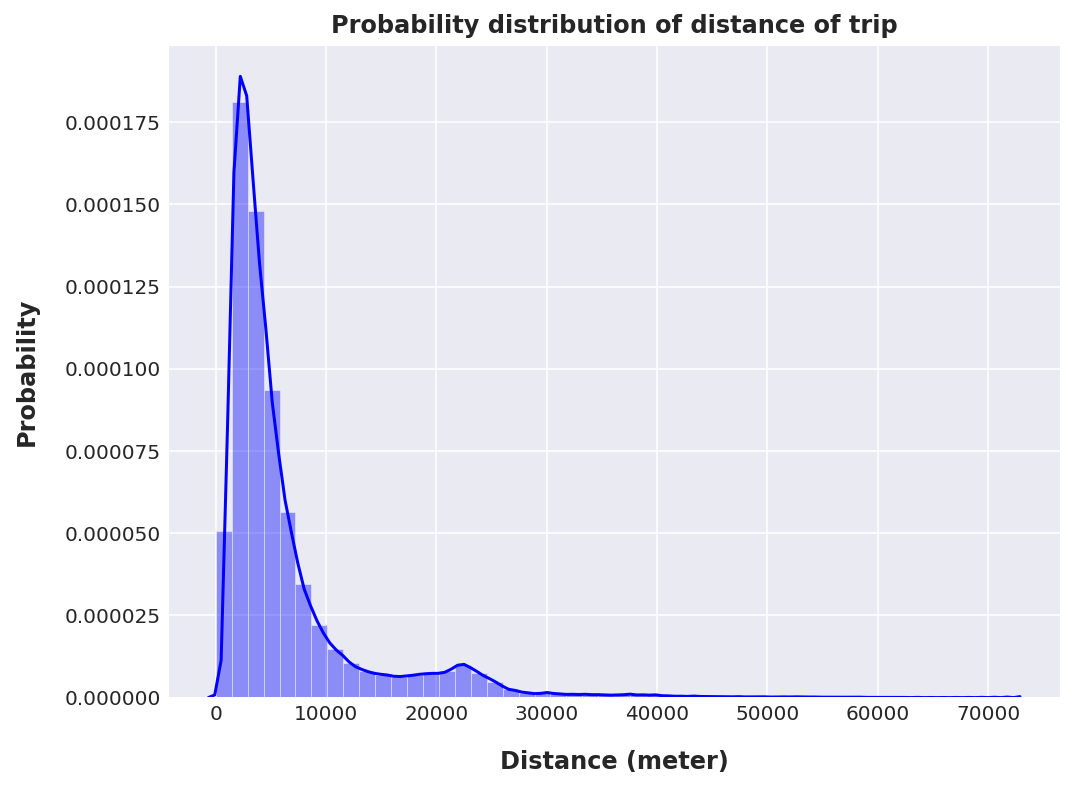

In [96]:
#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)

#Style of graph
sns.set_style('darkgrid')

#Plot the graph
sns.distplot(df['ride_distance'], color='blue')

#Axis Labels
plt.xlabel('Distance (meter)', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Probability', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Probability distribution of distance of trip', fontweight='bold', fontsize=12)


plt.show()

#### 2. Duration

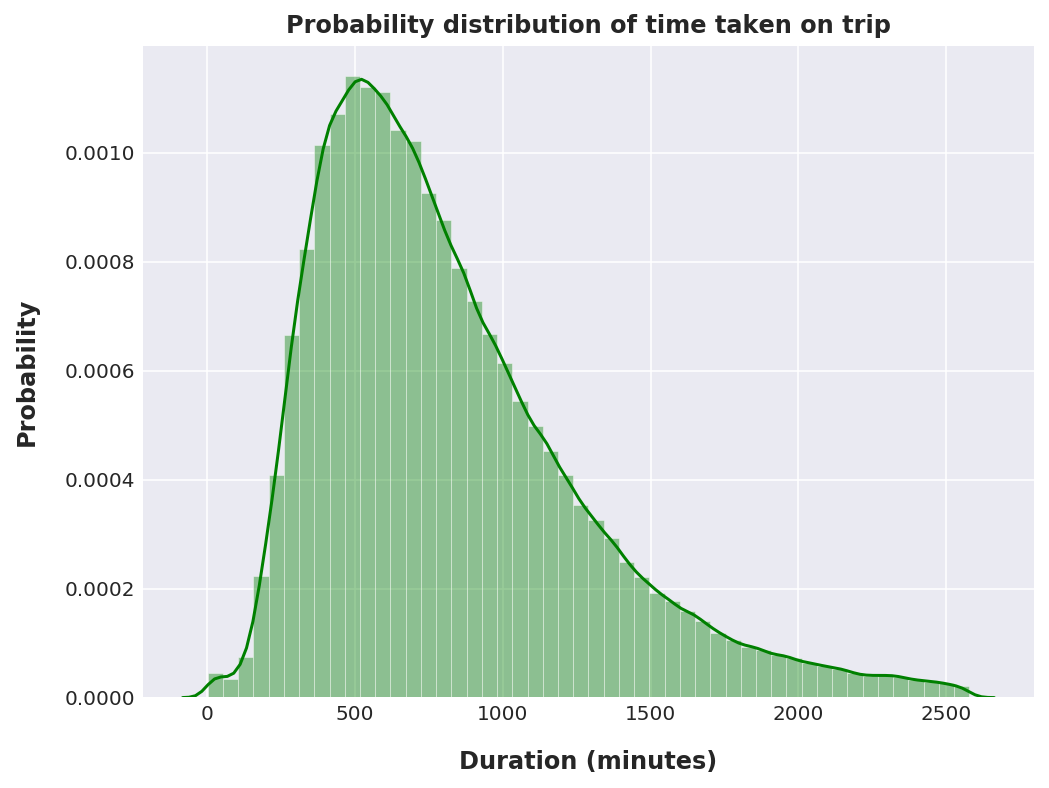

In [97]:
#Plot the graph
sns.distplot(df['ride_duration'], color='g')

#Axis Labels
plt.xlabel('Duration (minutes)', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Probability', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Probability distribution of time taken on trip', fontweight='bold', fontsize=12)

plt.show()

In [27]:
#g = df['month'].copy()
df['month']= pd.Categorical(df['month'], categories=['March/April','April/May','May/June'], ordered=True)

In [28]:
# A quick ordering of the plots
#w = df1['hour_category'].copy()
df['hour_category'] = pd.Categorical(df['hour_category'], 
                                     categories=['morning','afternoon', 'evening', 'night' ], ordered=True)

In [29]:
df.sort_values("timestamp", inplace=True) #sort the timestamp variable

In [30]:
df['timestamp'].min() #Find the minimum of the value

Timestamp('2016-03-28 05:48:18')

In [31]:
df['timestamp'].max() #Find the maximum of the value

Timestamp('2016-06-27 00:31:23')

#### Total number of trips -Monthly

In [32]:
df.groupby(['month'])['ride_id'].count() #duplicates

month
March/April    145649
April/May      369559
May/June       375675
Name: ride_id, dtype: int64

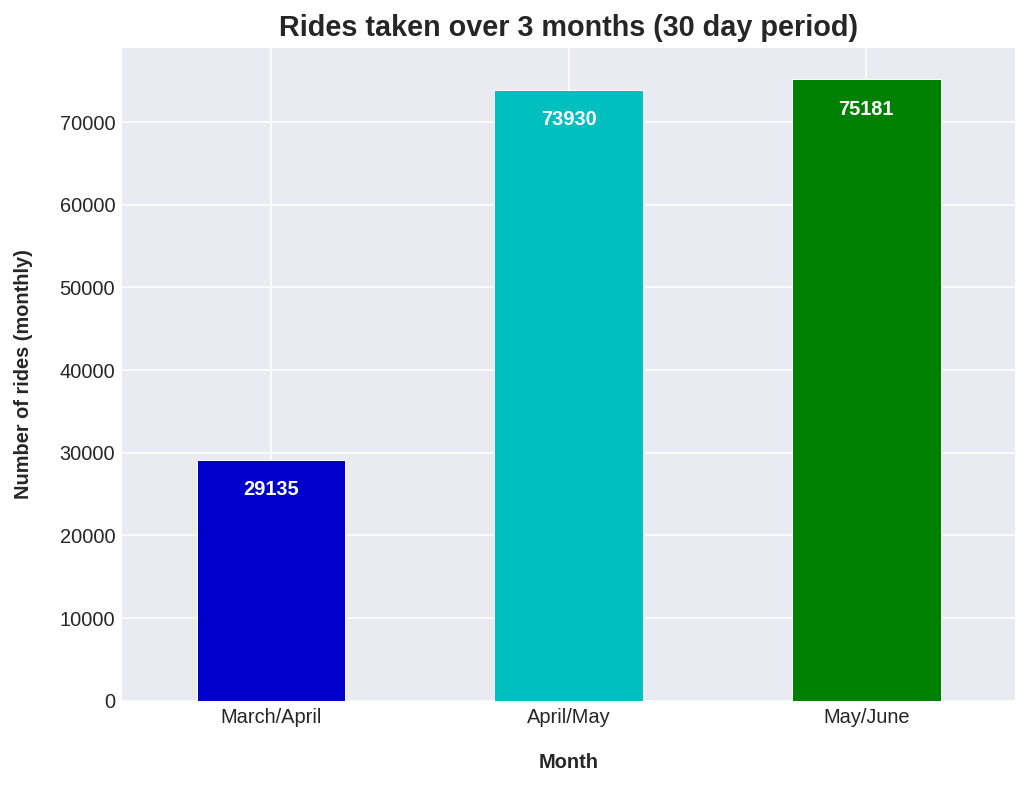

In [104]:
colors = ['mediumblue', 'c', 'green']
plt.style.use('seaborn-darkgrid')

#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)

#Graphing
graph1=df.groupby(['month'])['ride_id'].nunique()
ax=graph1.plot.bar(color=colors, grid=True)

#Axis Labels
plt.xlabel('Month', fontweight='bold', labelpad=13, fontsize=10)
plt.ylabel('Number of rides (monthly)', fontweight='bold', labelpad=13, fontsize=10)
plt.title('Rides taken over 3 months (30 day period)', fontweight='bold')
locs, labels = plt.xticks()
plt.setp(labels, rotation=360)

#Bar Labels
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, -15), textcoords='offset points', color='white', 
                fontweight='bold')

plt.show()



##### Week Days with the most trips

In [33]:
# A quick ordering of the plots
#d = df1['day_of_week'].copy()
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=['Monday','Tuesday','Wednesday', 'Thursday',
                                                                  'Friday', 'Saturday', 'Sunday'], ordered=True)

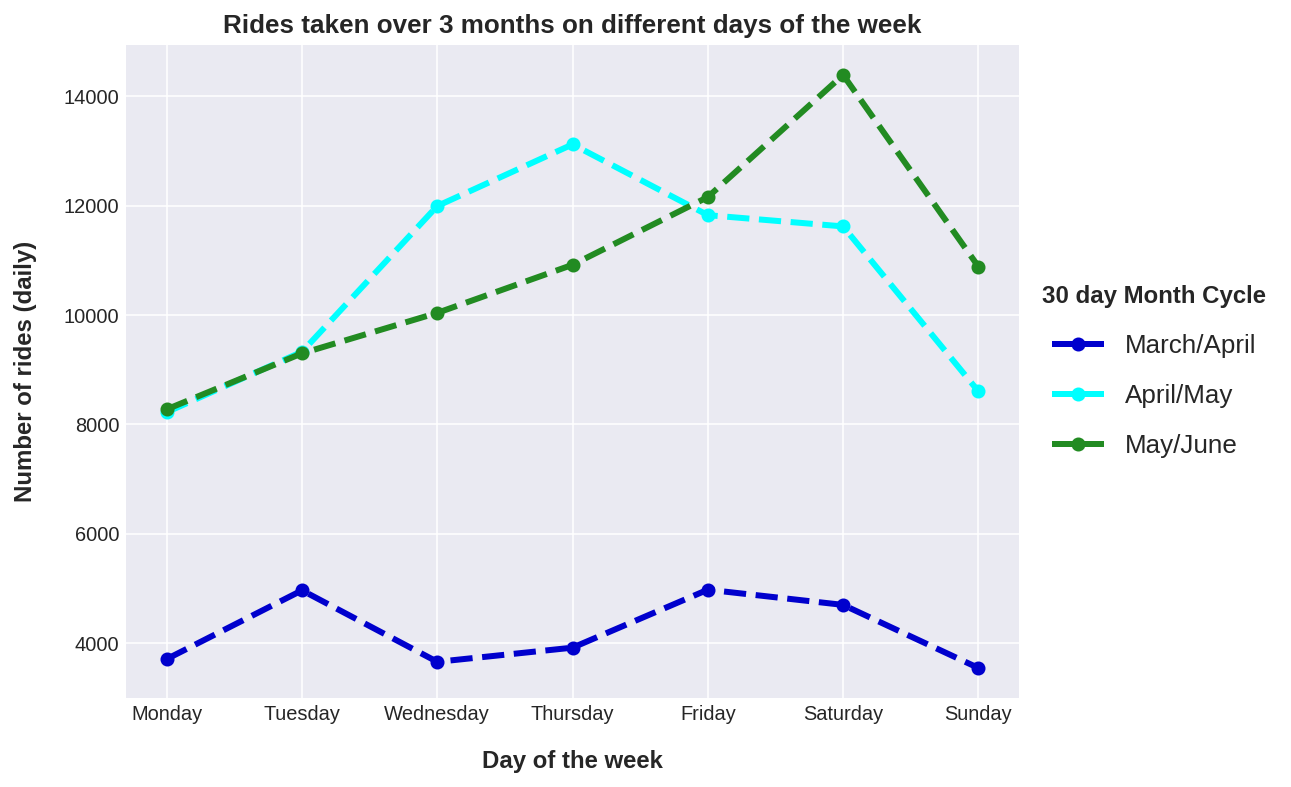

In [106]:
#Plotstyle
plt.style.use('seaborn-darkgrid')
colors = ['mediumblue', 'cyan', 'forestgreen']


#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)


#The graph
#graph= df.loc[df['event']== 'dropped_off_at'].reset_index().groupby(['day_of_week','month'])['ride_id'].count().unstack()
graph=df.groupby(['day_of_week','month'])['ride_id'].nunique().unstack()
ax=graph.plot.line(linewidth=3, color=colors, linestyle='--', marker='o')


#Axis Labels
plt.xlabel('Day of the week', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Number of rides (daily)', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Rides taken over 3 months on different days of the week', fontweight='bold', fontsize=13)

# Specify the x-axis labels and then rotate
labels= ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
locs, labels = plt.xticks()
plt.setp(labels, rotation=360)

#Legend
lg=ax.legend(['March/April', 'April/May', 'May/June'],
          title="30 day Month Cycle",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13, labelspacing=1)

title = lg.get_title()
title.set_fontsize(12)
title.set_weight('bold')

plt.show()

In [34]:
df.groupby(['month', 'hour_category'])['ride_id'].count().unstack()

hour_category,morning,afternoon,evening,night
month,,,,
March/April,33258,32112,50398,29881
April/May,89359,80162,125897,74141
May/June,93934,79371,123229,79141


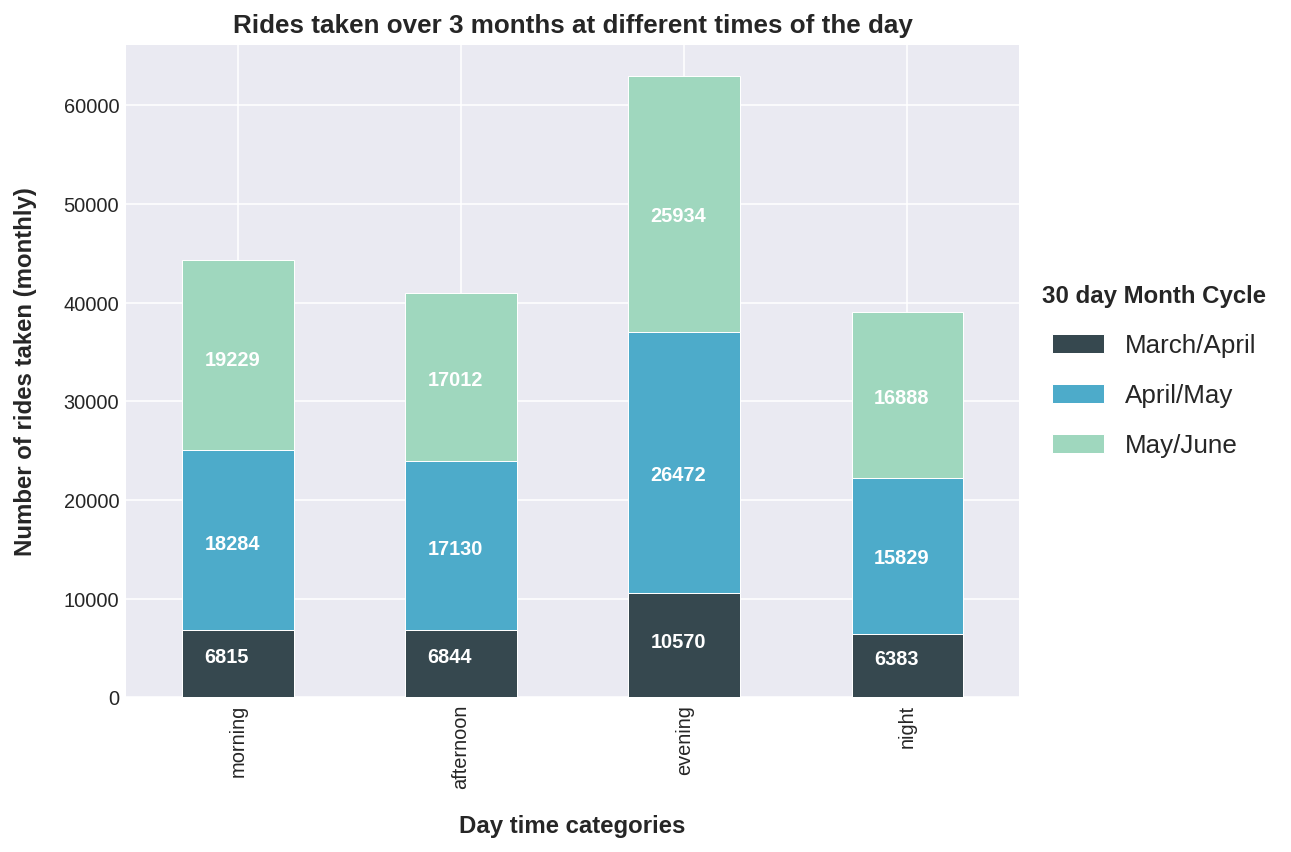

In [108]:
#Setting the style
from matplotlib.colors import ListedColormap  #import colourmap
plt.style.use('seaborn-darkgrid')

#Size of the figure
plt.rcParams["figure.figsize"]=8,6 #(width, height)  

#Plotting the graph
graph=df.set_index('month').groupby(['hour_category', 'month'])['ride_id'].nunique().unstack()
ax= graph.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette('GnBu_d', 10)))


#Axis labels and adjustments
plt.xlabel('Day time categories', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Number of rides taken (monthly)', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Rides taken over 3 months at different times of the day', fontweight='bold', fontsize=13)

#Legend
lg=ax.legend(['March/April', 'April/May', 'May/June'],
          title="30 day Month Cycle",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=13, labelspacing=1)

title = lg.get_title()
title.set_fontsize(12)
title.set_weight('bold')


#Bar Labels
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(height, (p.get_x()+.20*width, p.get_y()+.4*height),
             xytext=(0,4), textcoords='offset points',
                color='white', fontweight='bold')

    
plt.show()

In [35]:
#Calculating driver earnings

df['earnings_less_sf'] = (df['ride_distance']*1.15/1609.34) + (df['ride_duration']*0.22/60) + 2 
df['earnings_less_sf'] = np.where(df['earnings_less_sf'] > 400, 400, df['earnings_less_sf'])
df['earnings_less_sf'] = np.where(df['earnings_less_sf'] < 5, 5, df['earnings_less_sf'])

#Service fee calculation

df['service_fee'] = df['earnings_less_sf']*0.2

In [36]:
df_sum = df[df['date']!='2016-06-27'].groupby('date')['service_fee'].sum()

In [37]:
df2 = df_sum.reset_index().set_index('date', inplace=True)

In [38]:
ts = df_sum 

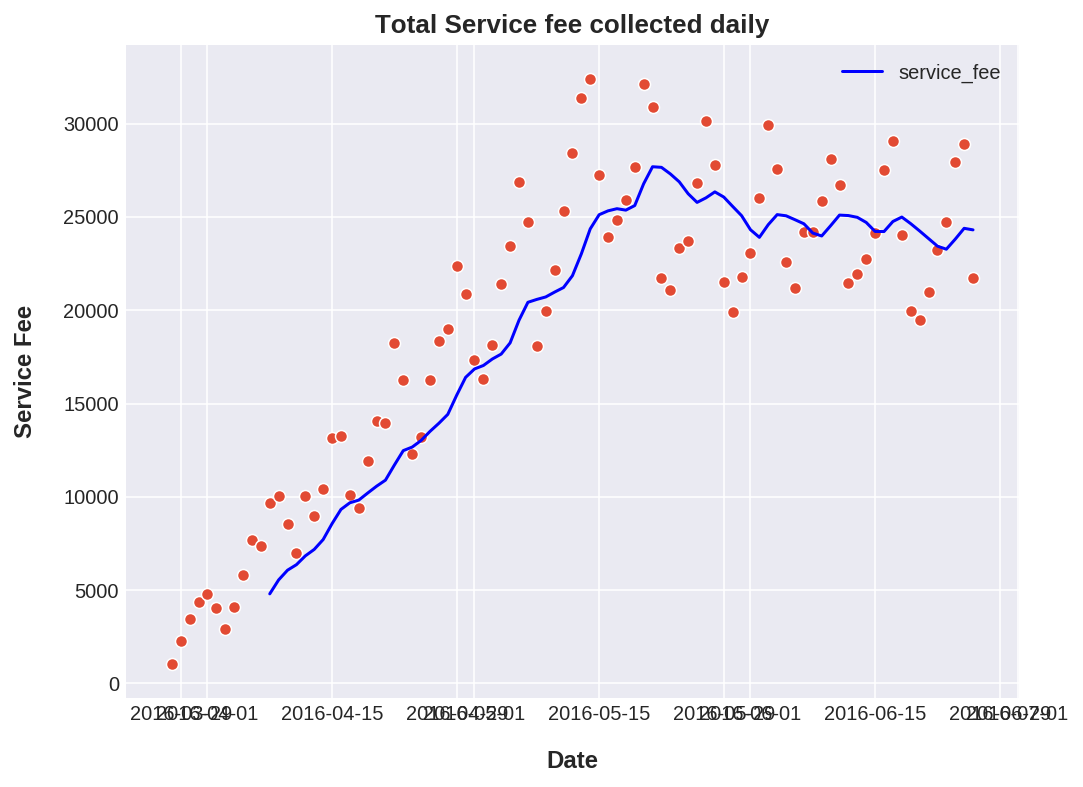

In [113]:
#Lineplot
moving_avg = ts.rolling(12).mean()
ax= plt.plot(moving_avg, color='blue')
#Scatterplot
sns.scatterplot(data=df_sum)


#Axis labels and adjustments
plt.xlabel('Date', fontweight='bold', labelpad=13, fontsize=12)
plt.ylabel('Service Fee', fontweight='bold', labelpad=13, fontsize=12)
plt.title('Total Service fee collected daily', fontweight='bold', fontsize=13)
#plt.xlim('2016-03-26', '2016-06-27')






plt.show()
 

In [39]:
cols_of_interest = ['driver_id', 'timestamp', 'service_fee']

In [40]:
df

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,driver_onboard_date,event,timestamp,day_of_week,hours,...,driver_last_activity,Fday_of_analysis,days_active,days_last_active,driver_waiting,rider_waiting,ride_duration_z,ride_distance_z,earnings_less_sf,service_fee
879155,f0df79d10df44f18742682108b17f60a,655ccbeb2a62880159e20e986c1cdaeb,40812,2112,25,2016-03-28,requested_at,2016-03-28 05:48:18,Monday,5.0,...,2016-06-24 05:49:48,2016-06-27 00:50:50,88,2,NaN,NaN,2.185807,2.185807,38.907384,7.781477
879156,f0df79d10df44f18742682108b17f60a,655ccbeb2a62880159e20e986c1cdaeb,40812,2112,25,2016-03-28,accepted_at,2016-03-28 05:48:23,Monday,5.0,...,2016-06-24 05:49:48,2016-06-27 00:50:50,88,2,NaN,NaN,2.185807,2.185807,38.907384,7.781477
879157,f0df79d10df44f18742682108b17f60a,655ccbeb2a62880159e20e986c1cdaeb,40812,2112,25,2016-03-28,arrived_at,2016-03-28 06:02:36,Monday,6.0,...,2016-06-24 05:49:48,2016-06-27 00:50:50,88,2,NaN,NaN,2.185807,2.185807,38.907384,7.781477
879158,f0df79d10df44f18742682108b17f60a,655ccbeb2a62880159e20e986c1cdaeb,40812,2112,25,2016-03-28,picked_up_at,2016-03-28 06:02:39,Monday,6.0,...,2016-06-24 05:49:48,2016-06-27 00:50:50,88,2,NaN,NaN,2.185807,2.185807,38.907384,7.781477
879159,f0df79d10df44f18742682108b17f60a,655ccbeb2a62880159e20e986c1cdaeb,40812,2112,25,2016-03-28,dropped_off_at,2016-03-28 06:37:51,Monday,6.0,...,2016-06-24 05:49:48,2016-06-27 00:50:50,88,2,NaN,NaN,2.185807,2.185807,38.907384,7.781477
916945,ff714a67ba8c6a108261cd81e3b77f3a,e81c8bdc2a6a9056ba49bf67bf97c311,9384,1653,0,2016-03-28,requested_at,2016-03-28 08:11:39,Monday,8.0,...,2016-06-17 09:40:18,2016-06-27 00:50:50,81,9,NaN,NaN,1.384543,1.384543,14.766606,2.953321
916946,ff714a67ba8c6a108261cd81e3b77f3a,e81c8bdc2a6a9056ba49bf67bf97c311,9384,1653,0,2016-03-28,accepted_at,2016-03-28 08:11:44,Monday,8.0,...,2016-06-17 09:40:18,2016-06-27 00:50:50,81,9,NaN,NaN,1.384543,1.384543,14.766606,2.953321
916947,ff714a67ba8c6a108261cd81e3b77f3a,e81c8bdc2a6a9056ba49bf67bf97c311,9384,1653,0,2016-03-28,arrived_at,2016-03-28 08:14:12,Monday,8.0,...,2016-06-17 09:40:18,2016-06-27 00:50:50,81,9,NaN,NaN,1.384543,1.384543,14.766606,2.953321
916948,ff714a67ba8c6a108261cd81e3b77f3a,e81c8bdc2a6a9056ba49bf67bf97c311,9384,1653,0,2016-03-28,picked_up_at,2016-03-28 08:14:13,Monday,8.0,...,2016-06-17 09:40:18,2016-06-27 00:50:50,81,9,NaN,NaN,1.384543,1.384543,14.766606,2.953321
916949,ff714a67ba8c6a108261cd81e3b77f3a,e81c8bdc2a6a9056ba49bf67bf97c311,9384,1653,0,2016-03-28,dropped_off_at,2016-03-28 08:41:46,Monday,8.0,...,2016-06-17 09:40:18,2016-06-27 00:50:50,81,9,NaN,NaN,1.384543,1.384543,14.766606,2.953321


#### Summary of purchase activity: Frequency, recency and time

In [41]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *

data = summary_data_from_transaction_data(df, 'driver_id', 'timestamp', monetary_value_col='service_fee', 
                                          observation_period_end='2016-06-27')

-  Frequency: Represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
-  T: represents the age of the customer in whatever time units chosen (daily, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
-  Recency: Represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

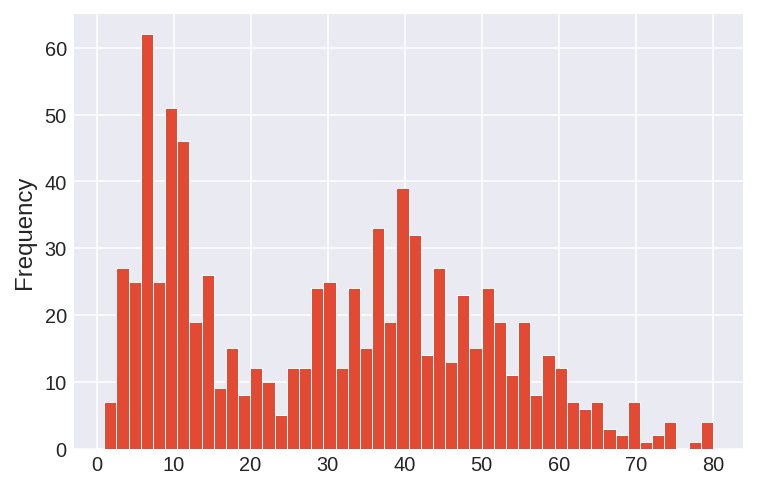

In [156]:
data['frequency'].plot(kind='hist', bins=50)
plt.show()

In [42]:
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

count    837.000000
mean      30.227001
std       19.266914
min        1.000000
25%       11.000000
50%       31.000000
75%       45.000000
max       80.000000
Name: frequency, dtype: float64
0.0


# 4. Model

We estimate future client activity using the Pareto/NBD model, which is frequently applied probabilistic model in the non-contractual context.

In [43]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 837 subjects, a: 0.47, alpha: 7.56, b: 27.46, r: 3.96>


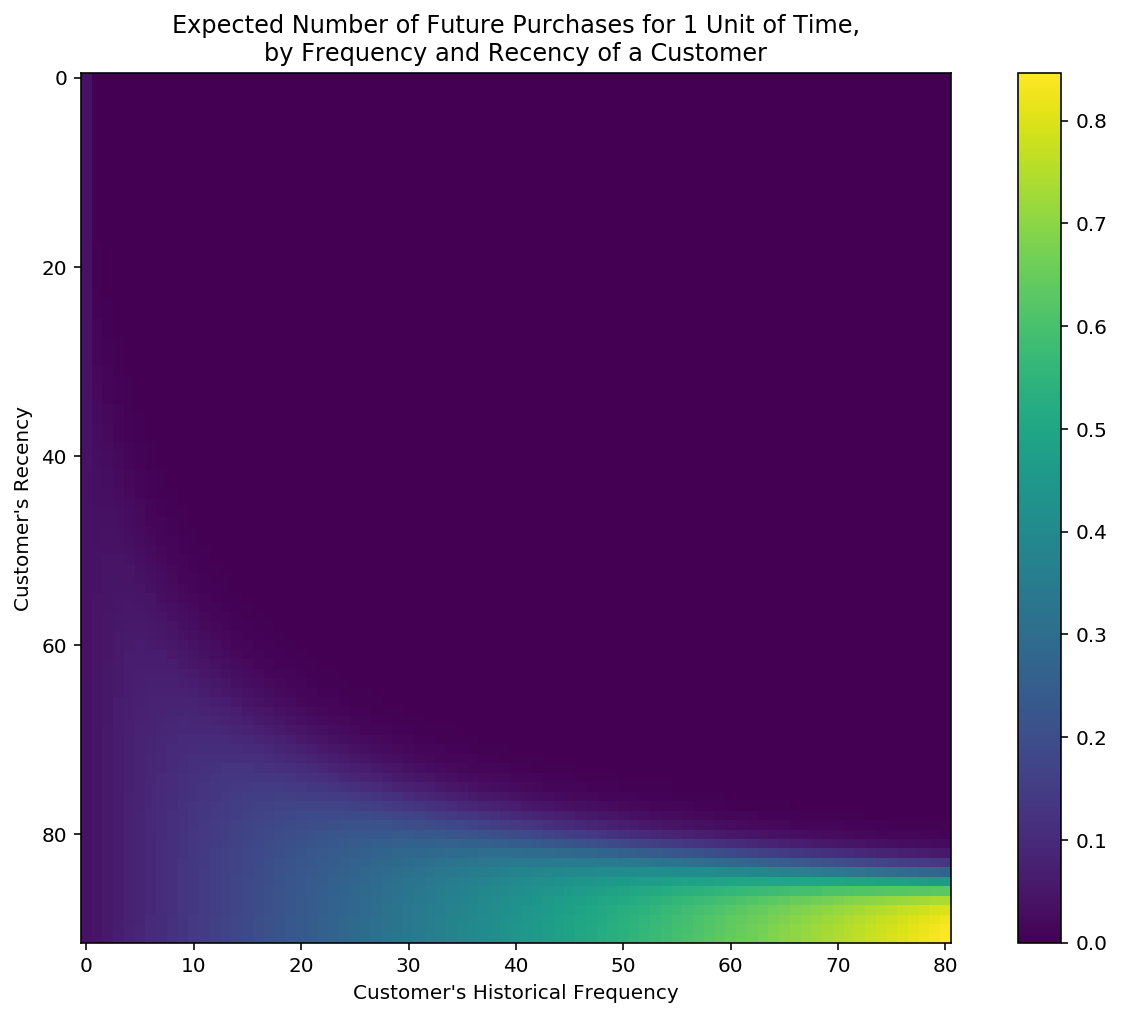

In [43]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)
plt.show()

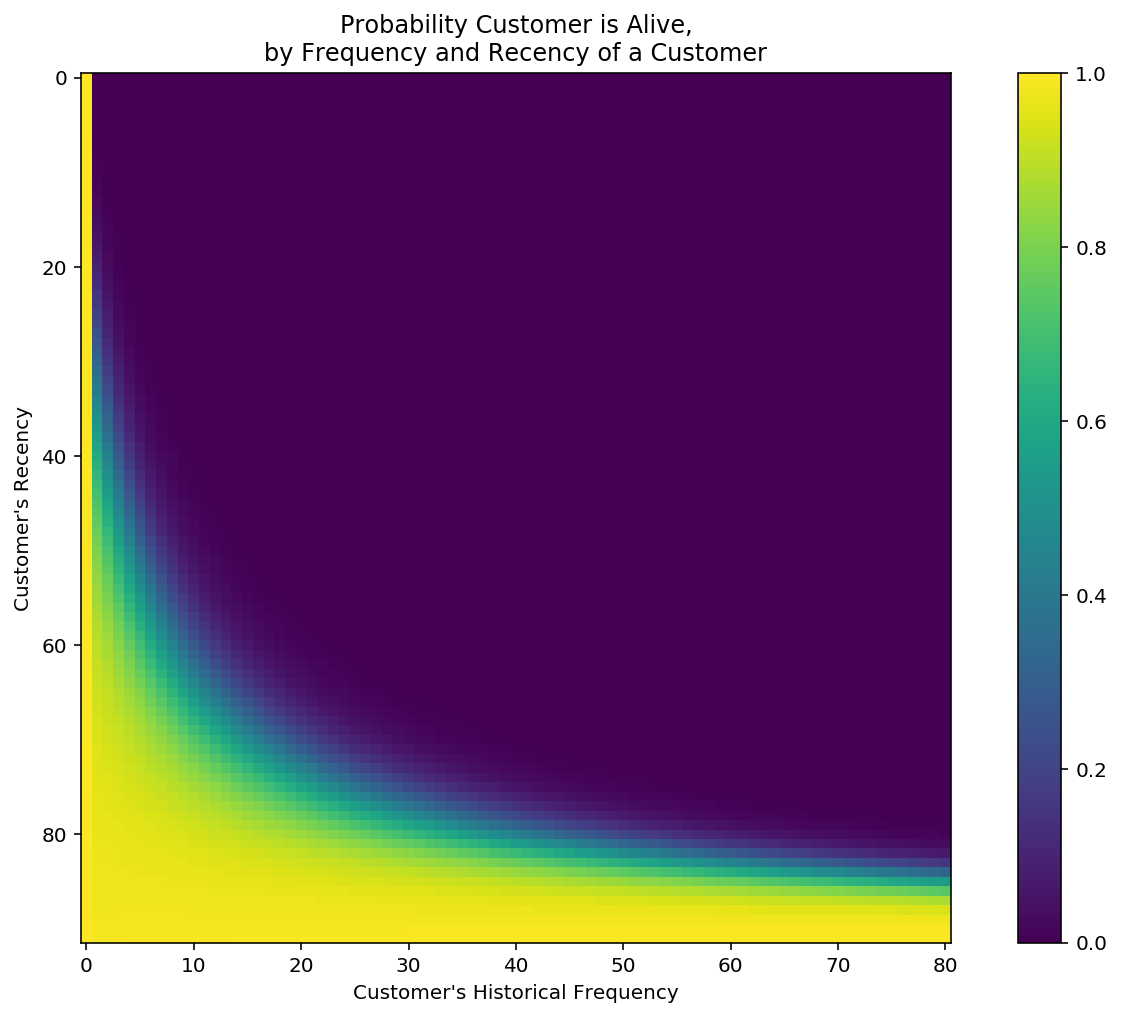

In [44]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)
plt.show()

In [44]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      data['frequency'], 
                                                                                      data['recency'], 
                                                                                      data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
driver_id,,,,,
ef3e90cd957439dcf1a2afcfc4b0cad7,60.0,61.0,62.0,69.692762,0.904727
55bec90600d21bd3513366d218f2b2f2,47.0,48.0,48.0,125.673818,0.908675
5943b68c2fa8bcfd0add30691fd9136b,80.0,84.0,84.0,68.399514,0.911098
531a726b5b0c925a1aa24b5a9d5ac333,80.0,82.0,83.0,63.754537,0.914919
86a1dbd33d3ee6d68caa25966a2868a3,58.0,58.0,59.0,92.623404,0.915410


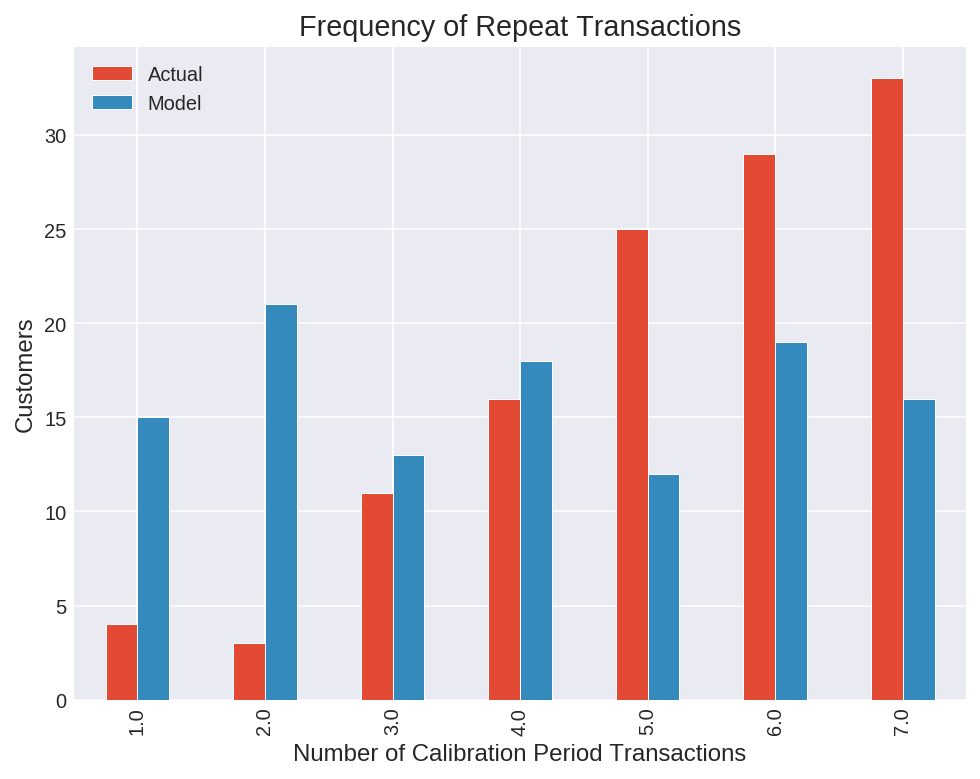

In [58]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [45]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'driver_id', 'timestamp',
                                        calibration_period_end='2016-05-01',
                                        observation_period_end='2016-06-27' )   
print(summary_cal_holdout.head())

                                  frequency_cal  recency_cal  T_cal  \
driver_id                                                             
002be0ffdc997bd5c50703158b7c2491           22.0         29.0   33.0   
007f0389f9c7b03ef97098422f902e62            4.0         31.0   33.0   
011e5c5dfc5c2c92501b8b24d47509bc            4.0         21.0   26.0   
0152a2f305e71d26cc964f8d4411add9            5.0          5.0    6.0   
01674381af7edd264113d4e6ed55ecda            0.0          0.0    2.0   

                                  frequency_holdout  duration_holdout  
driver_id                                                              
002be0ffdc997bd5c50703158b7c2491               33.0                57  
007f0389f9c7b03ef97098422f902e62                7.0                57  
011e5c5dfc5c2c92501b8b24d47509bc                6.0                57  
0152a2f305e71d26cc964f8d4411add9               36.0                57  
01674381af7edd264113d4e6ed55ecda               39.0                57 

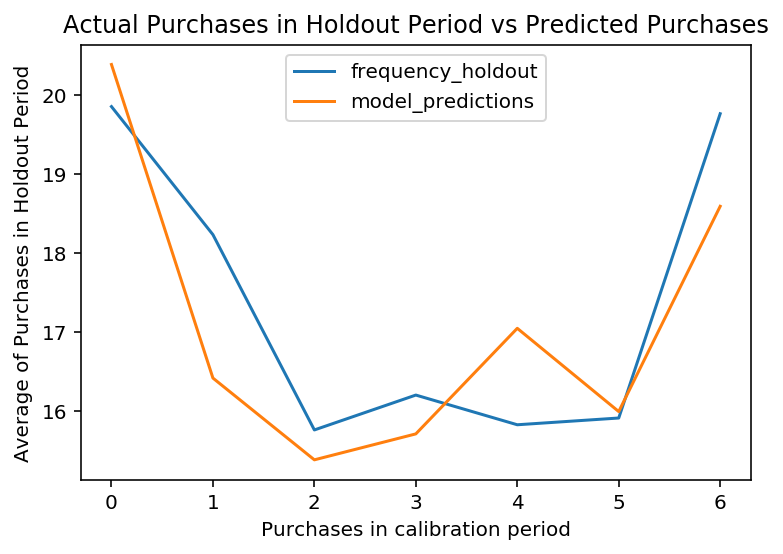

In [46]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In this plot, we separate the data into both a in-sample (calibration) and validation (holdout) period.
The sample period consists the beginning to 2016–03–28; the validation period spans from 2016–05–01 to 
2016–06–27. The plot groups all customers in the calibration period by their number of repeat purchases 
(x-axis) and then averages over their repeat purchases in the holdout period (y-axis). 
The orange and blue line presents the model prediction and actual result of the y-axis respectively. 
As we can see, our model is able to very accurately predict the customer base’s behaviour out of the sample, 
the model under-estimates some of the purchases, however, the model also suffers from seasonality given that on some days of the week, hour and months the drivers received more requests for a taxi ride.

### Further more we want to estimate a customers transaction prediction for our 200th driver on the platform

In [54]:
t = 10
individual = data.iloc[400]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

7.115343275457315

Our model predicts that driver(400) will have 7.115 trips in the next 10 days.

### Estimating customer lifetime value using gamma-gamma model of monetary value

Now we take into account the economic value of each transaction, using the Gamma-Gamma submodel presented by Dr. Peter Fader and Dr. Bruce Hardie from Wharton, to predict likely spend per trip in the future ata driver level.

In [55]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

                                  frequency  recency     T  monetary_value  \
driver_id                                                                    
002be0ffdc997bd5c50703158b7c2491       55.0     86.0  90.0       43.926527   
007f0389f9c7b03ef97098422f902e62       11.0     85.0  90.0       19.663631   
011e5c5dfc5c2c92501b8b24d47509bc       10.0     68.0  83.0       26.574248   
0152a2f305e71d26cc964f8d4411add9       41.0     62.0  63.0       48.371456   
01674381af7edd264113d4e6ed55ecda       39.0     56.0  59.0      102.791458   

                                  predicted_purchases  
driver_id                                              
002be0ffdc997bd5c50703158b7c2491             0.564681  
007f0389f9c7b03ef97098422f902e62             0.149066  
011e5c5dfc5c2c92501b8b24d47509bc             0.132508  
0152a2f305e71d26cc964f8d4411add9             0.627432  
01674381af7edd264113d4e6ed55ecda             0.611940  
837


In [56]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 837 subjects, p: 0.33, q: 27.94, v: 5427.24>


After applying Gamma-Gamma model, now we can estimate average trip value for each driver.

In [57]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

driver_id
002be0ffdc997bd5c50703158b7c2491    57.417109
007f0389f9c7b03ef97098422f902e62    60.945107
011e5c5dfc5c2c92501b8b24d47509bc    62.150208
0152a2f305e71d26cc964f8d4411add9    60.444101
01674381af7edd264113d4e6ed55ecda    78.242774
0213f8b59219e32142711992ca4ec01f    72.747307
021e5cd15ef0bb3ec20a12af99e142b3    59.894375
0258e250ca195cc6258cbdc75aecd853    69.791614
028b5a4dcd7f4924ebfabcf2e814c014    77.268838
02d6a6b8a6da15fc219a9570f7ebbe78    59.524068
dtype: float64


This gives an estimate of the lifetime value for each driver that has had one or more repeat trip over the past 3 month